# Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, r2_score, confusion_matrix
import os, csv, random, time
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Functions

In [2]:
def my_preprocessing(df, droplist, processing_type, trainingdata = True, scaler = None):
    X = df.drop(columns=droplist, inplace=False)
    X.drop(columns=['id', 'satisfaction_satisfied'], inplace=True)
    fs = X.columns.tolist()
    if processing_type == 'Normalization':
        if trainingdata:
            scaler = MinMaxScaler()
            scaler = scaler.fit(X)
        X = scaler.transform(X)
    elif processing_type == 'Standardization':
        X_binary_colname = ['Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']
        X.drop(columns=X_binary_colname, inplace=True)
        if trainingdata:
            scaler = StandardScaler()
            scaler = scaler.fit(X)
        X = scaler.transform(X)
        X = np.concatenate((X, np.array(df[X_binary_colname])), axis=1)
    return X, fs, scaler

In [3]:
def my_metrics(model, X_train, X_test, y_train, y_test, print_model=True):
    y_pred = model.predict(X_test)
    metric_dict = {}
    metric_dict['accuracy(train)'] = model.score(X_train, y_train)
    metric_dict['accuracy(test)'] = model.score(X_test, y_test)
    metric_dict['precision'] = precision_score(y_test, y_pred)
    metric_dict['recall'] = recall_score(y_test, y_pred)
    metric_dict['f1-score'] = f1_score(y_test, y_pred)
    if print_model:
        print(model)
        print("\n".join("{!r}: {!r},".format(k, v) for k, v in metric_dict.items()))
    return metric_dict

In [4]:
def acc_pre_rec_f1(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=1))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))

In [5]:
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    y_pred_prob = y_pred_probabilities[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'{classifier_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.show()
    
    return print(f'AUC Score (ROC): {roc_auc_score(y_test, y_pred_prob)}\n')

In [6]:
def confusionMatrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [7]:
def draw_pies(df_train, col_name_list, dpi=150):    
    def label_function(val):
        return f'{val / 100 * len(df_train):.0f}\n{val:.0f}%'
    fgsize = (3, 2.5)
    if len(col_name_list) == 4:
        fgsize = (7, 5)
        nr, nc = 2, 2
    elif len(col_name_list) == 6:
        fgsize = (7, 5)
        nr, nc = 3, 2
    elif len(col_name_list) == 8:
        fgsize = (7, 5)
        nr, nc = 4, 2
    elif len(col_name_list) == 9:
        fgsize = (7, 5)
        nr, nc = 3, 3
    else:
        fgsize = (1+3*len(col_name_list), 2.5)
        nr, nc = 1, len(col_name_list)
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=fgsize, dpi=dpi)

    if (nr, nc) != (1,1):
        for i, aax in enumerate(axes.flatten()):
            df_train.groupby(col_name_list[i]).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 6}, ax=aax, colors = sns.color_palette('Set2'))
            aax.set_ylabel('')#val_name, size=7)
            aax.set_title(str(col_name_list[i]).title(), size=8)
    
    else:
        print('one pie')
        # df.groupby(val_name).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 6}, ax=axes, colors = sns.color_palette('Set2')[1:])#[0:2]['tomato', 'gold', 'skyblue'])
        df_train.groupby(col_name_list[0]).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 6}, ax=axes, colors = sns.color_palette('Set2'))
        axes.set_ylabel('')#val_name, size=7)
        axes.set_title(str(col_name_list[0]).title(), size=8)
    # plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.9, hspace=.9)
    # plt.suptitle(str('pie').title(), size=11)
    plt.tight_layout()
    plt.show()

In [8]:
def xy_pie(df_train, group_name, val_name, dpi=150):  
    unique_item = np.sort(df_train[group_name].unique())
    gp_df = df_train.groupby(group_name)
    
    fgsize = (5, 2)
    if len(unique_item) == 4:
        nr, nc = 2, 2
    elif len(unique_item) == 6:
        fgsize = (7, 5)
        nr, nc = 3, 2
    elif len(unique_item) == 8:
        fgsize = (7, 5)
        nr, nc = 4, 2
    elif len(unique_item) == 9:
        fgsize = (7, 5)
        nr, nc = 3, 3
    else:
        nr, nc = 1, len(unique_item)
    fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=fgsize, dpi=dpi)

    if (nr, nc) != (1,1):
        for i, aax in enumerate(axes.flatten()):
            df = gp_df.get_group(unique_item[i])
            def label_function(val):
                return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
            df.groupby(val_name).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 6}, ax=aax, colors = sns.color_palette('Set2')[1:])#, , colors=colors = sns.color_palette('pastel'))colors=['tomato', 'gold', 'skyblue'])
            aax.set_ylabel('')#val_name, size=7)
            aax.set_title(str(unique_item[i]).title(), size=8)
    
    else:
        print('U r wrong')
        df = gp_df.get_group(unique_item[0])
        def label_function(val):
            return f'{val / 100 * len(df):.0f}\n{val:.0f}%'
        df.groupby(val_name).size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 6}, ax=axes, colors = sns.color_palette('Set2')[1:])#[0:2]['tomato', 'gold', 'skyblue'])
        axes.set_ylabel('')#val_name, size=7)
        axes.set_title(str(unique_item[0]).title(), size=8)
    # plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=.2, hspace=.9)
    plt.suptitle(str(group_name).title() + ' to ' + str(val_name).title(), size=10)
    plt.tight_layout()
    plt.show()

In [9]:
def draw_satisfaction(df_train, col_name):
    tmpdf = df_train.groupby("satisfaction").get_group('satisfied')[[col_name, 'satisfaction']]
    tmpdf = tmpdf.append(df_train.groupby("satisfaction").get_group('neutral or dissatisfied')[[col_name, 'satisfaction']])
    tmpdf
    sns.set(rc={"figure.dpi":70})
    plt.rcParams['figure.figsize']=(1 + 3 * 2, 4)
    sns.countplot(x="satisfaction", hue=col_name, data=tmpdf.astype({"satisfaction": str, col_name: int}), palette = sns.color_palette('Set2'))
    # plt.title('Score distribution')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Score")
    plt.title(col_name)
    plt.show()

In [10]:
def draw_bars(df_train, col_list, legend_title = None, dpi = 70):
    df = df_train[col_list]
    sns.set(rc={"figure.dpi":dpi})
    plt.rcParams['figure.figsize']=(1 + 3 * len(col_list), 4)
    sns.countplot(x="variable", hue="value", data=pd.melt(df), palette = sns.color_palette('Set2'))
    # plt.title('Score distribution')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title=legend_title)
    plt.show()

In [11]:
def draw_nan(df_train, col_name):
    data = [df_train[col_name].isna().sum(), df_train.shape[0]-df_train[col_name].isna().sum()]
    labels = ['Nan', 'not Nan']

    fig1, ax1 = plt.subplots(figsize=(5, 2), dpi=150)

    colors = sns.color_palette('Set2')

    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{v:d}\n{p:.1f}%'.format(p=pct,v=val)
        return my_autopct


    ax1.pie(data, labels = labels, colors = colors, autopct=make_autopct(data), textprops={'fontsize': 6})
    plt.title('Nan (' + col_name + ')', size = 8)
    plt.show()

# Load data and set configuration

In [12]:
PATH = Path('')
processing = 'Normalization'

In [13]:
df_train = pd.read_csv(PATH / 'train.csv')
df_train.drop(columns='Unnamed: 0', inplace=True)

In [14]:
df_test = pd.read_csv(PATH / 'test.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)

# Data Exploration

In [15]:
df_train

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied


資料筆數與欄位數

In [16]:
df_train.shape

(103904, 24)

In [17]:
df_test.shape

(25976, 24)

檢查是否有缺值

In [18]:
df_train.isnull().sum(axis = 0)

id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Arrival Delay in Minutes有缺310個，佔全部0.3%（下圖）

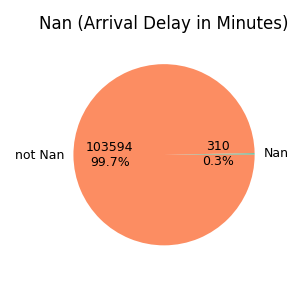

In [19]:
draw_nan(df_train, 'Arrival Delay in Minutes')

## 資料分布情形

In [20]:
df_train.columns

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

### Histogram

In [21]:
sns.set(rc={"figure.dpi":80})
plt.rcParams['figure.figsize']=(9, 5)

array([[<AxesSubplot:title={'center':'Flight Distance'}>]], dtype=object)

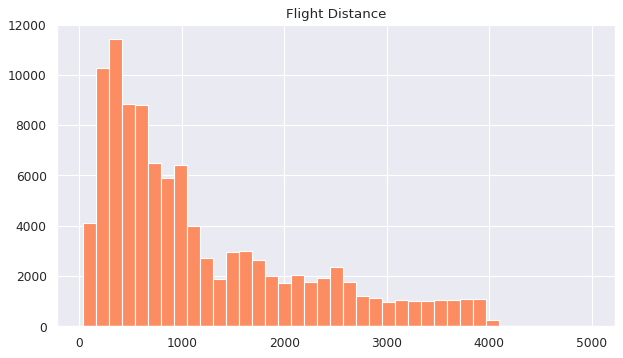

In [22]:
df_train.hist(column = 'Flight Distance', bins=round(1 + 3.322 * np.log(len(df_train))), color = sns.color_palette('Set2')[1])

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

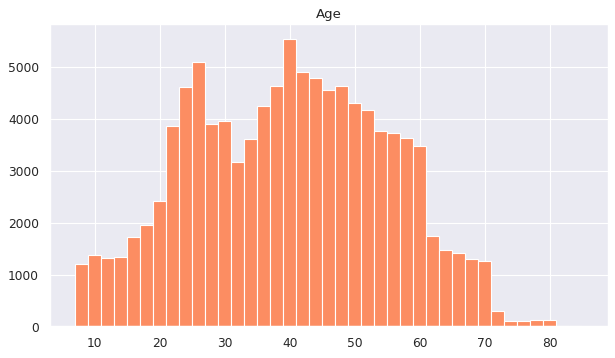

In [23]:
df_train.hist(column = 'Age', bins=round(1 + 3.322 * np.log(len(df_train))), color = sns.color_palette('Set2')[1])

array([[<AxesSubplot:title={'center':'Departure Delay in Minutes'}>]],
      dtype=object)

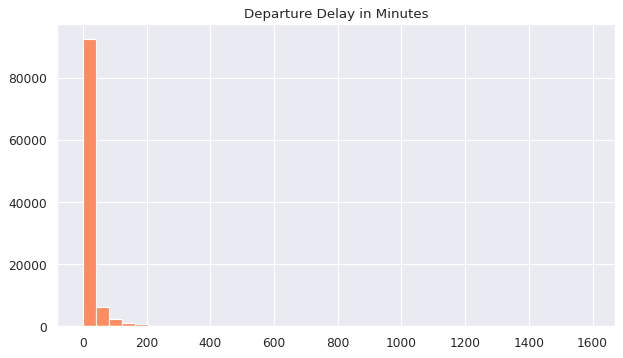

In [24]:
df_train.hist(column = 'Departure Delay in Minutes', bins=round(1 + 3.322 * np.log(len(df_train))), color = sns.color_palette('Set2')[1])

array([[<AxesSubplot:title={'center':'Arrival Delay in Minutes'}>]],
      dtype=object)

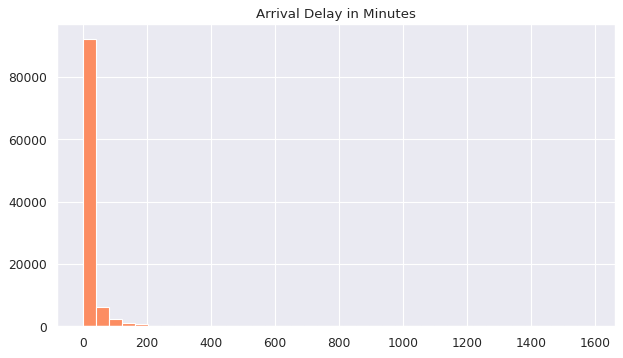

In [25]:
df_train.hist(column = 'Arrival Delay in Minutes', bins=round(1 + 3.322 * np.log(len(df_train))), color = sns.color_palette('Set2')[1])

### bar

重要的那幾個

In [26]:
# bar_ls = ['Leg room service', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Gate location', 'On-board service', 'Inflight entertainment', 'Online boarding']
# draw_bars(df_train, bar_ls, legend_title = 'Score', dpi=150)

所有評分的

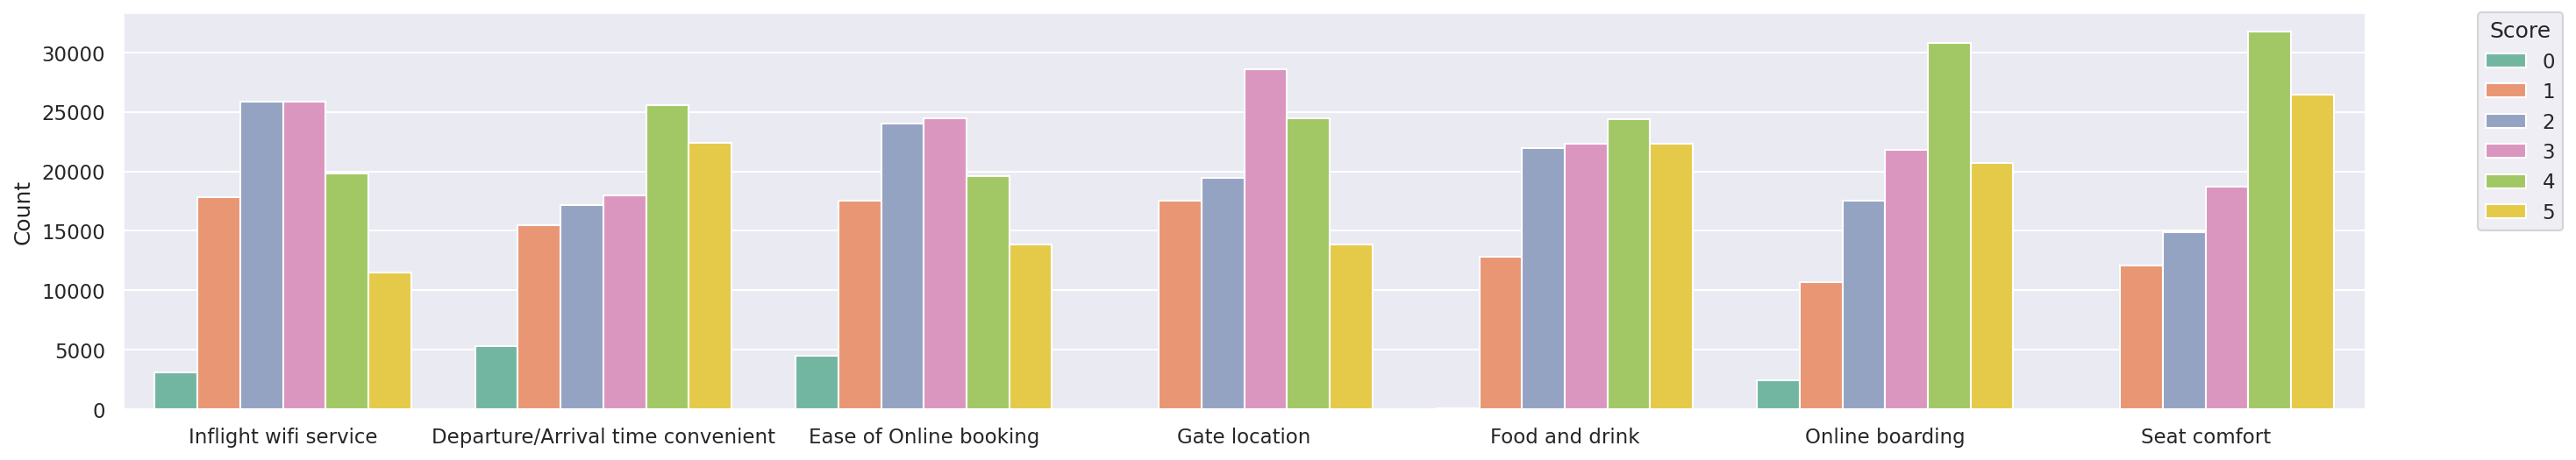

In [27]:
bar_ls = ['Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort']
draw_bars(df_train, bar_ls, legend_title = 'Score', dpi=150)

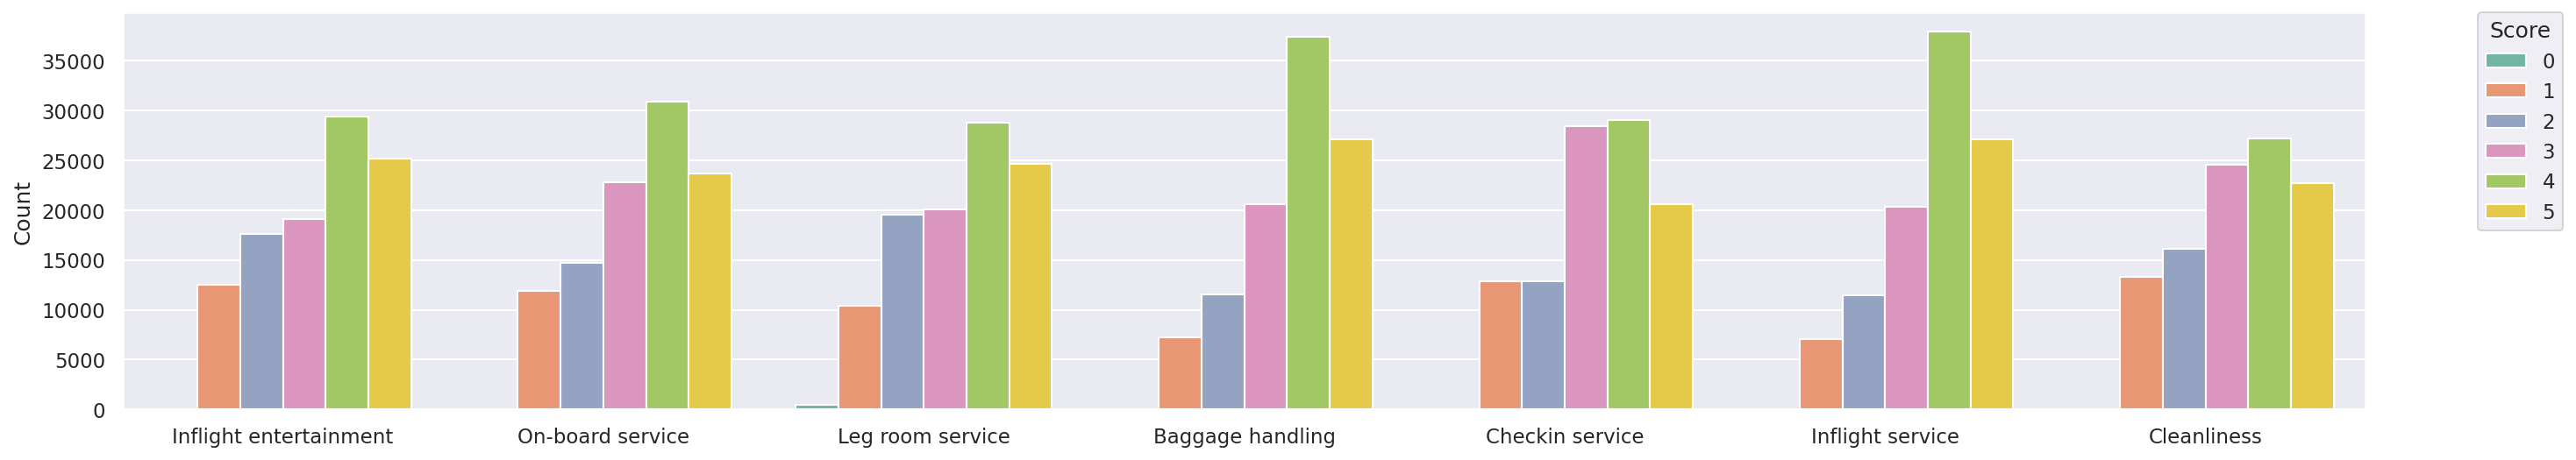

In [28]:
bar_ls = ['Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']
draw_bars(df_train, bar_ls, legend_title = 'Score', dpi=150)

### Pie

In [29]:
# pie_ls = ['Inflight wifi service',
#        'Departure/Arrival time convenient', 'Ease of Online booking',
#        'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort']
# draw_pies(df_train, pie_ls)

In [30]:
# pie_ls = ['Inflight entertainment', 'On-board service', 'Leg room service',
#        'Baggage handling', 'Checkin service', 'Inflight service',
#        'Cleanliness']
# draw_pies(df_train, pie_ls)

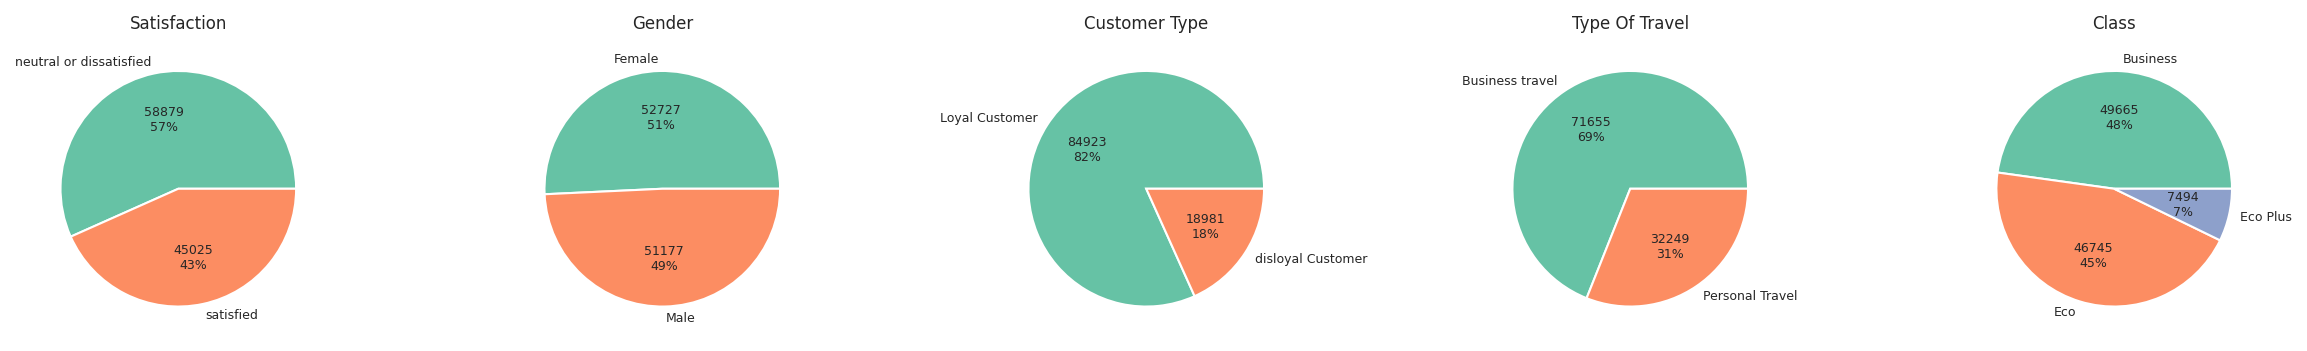

In [31]:
pie_ls = ['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']
draw_pies(df_train, pie_ls)#, dpi=300)

針對單一項目畫

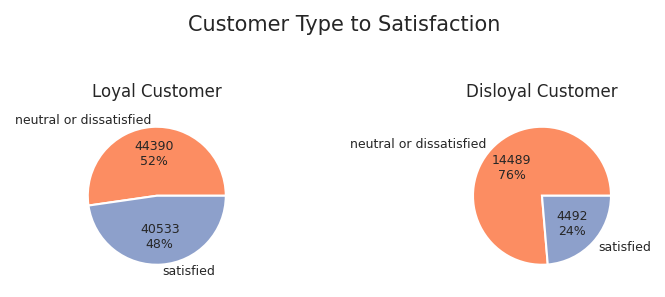

In [32]:
xy_pie(df_train, group_name='Customer Type', val_name='satisfaction')#,dpi=300)

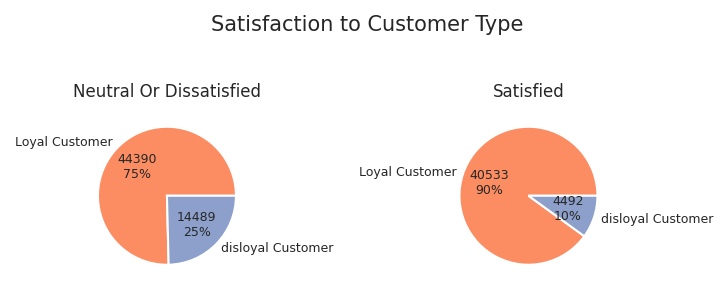

In [33]:
xy_pie(df_train, group_name='satisfaction', val_name='Customer Type')#, dpi=300)

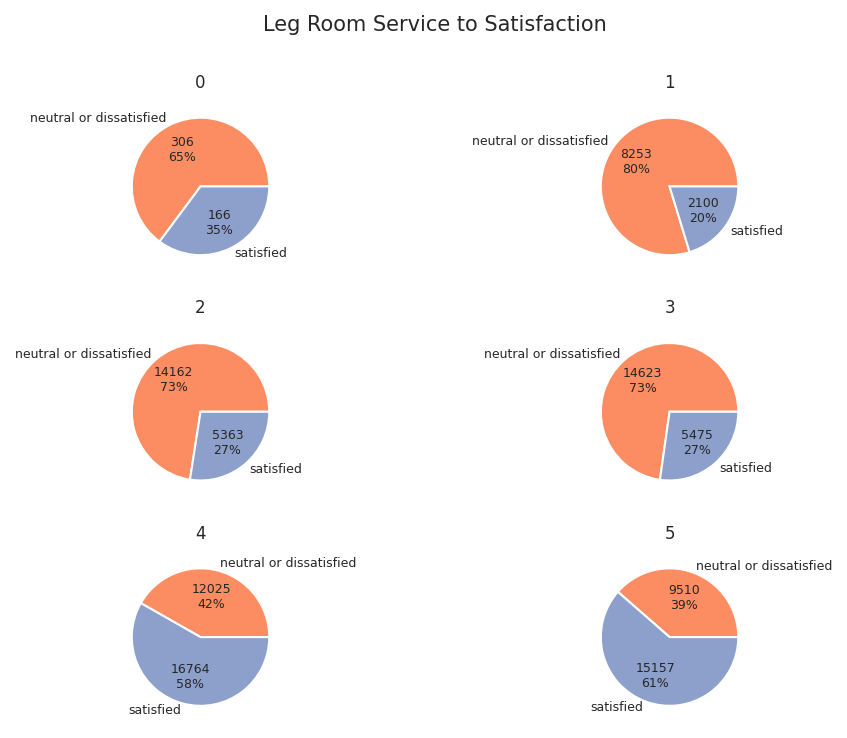

In [34]:
xy_pie(df_train, group_name='Leg room service', val_name='satisfaction')#, dpi=300)

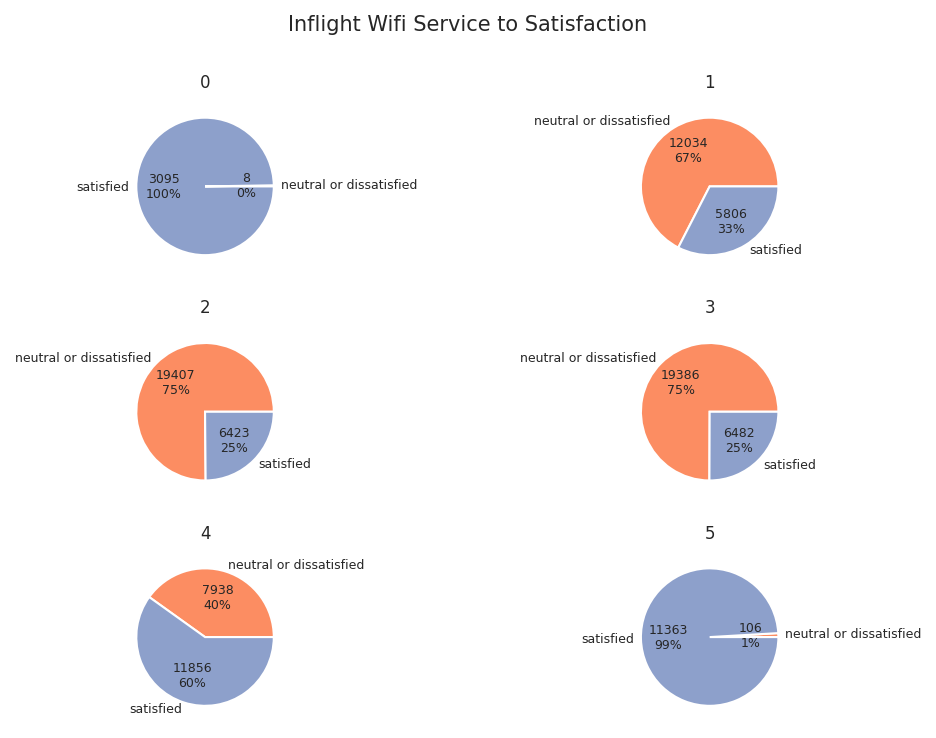

In [35]:
xy_pie(df_train, group_name='Inflight wifi service', val_name='satisfaction')#, dpi=300)

發現0的大部分都是滿意，到原資料集討論頁面才發現0應屬於缺失值

滿不滿意族群在某一指標的分布

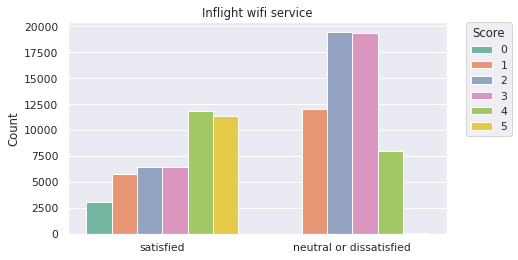

In [36]:
draw_satisfaction(df_train, 'Inflight wifi service')

# Preprocessing

## 1. 把score的0用np.nan代替

In [37]:
score_col = ['Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort','Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']
df_train[score_col] = df_train[score_col].replace(0, np.nan)
df_test[score_col] = df_test[score_col].replace(0, np.nan)
# df_train.isnull().sum(axis = 0)

In [38]:
df_train.isnull().sum(axis = 0)

id                                      0
Gender                                  0
Customer Type                           0
Age                                     0
Type of Travel                          0
Class                                   0
Flight Distance                         0
Inflight wifi service                3103
Departure/Arrival time convenient    5300
Ease of Online booking               4487
Gate location                           1
Food and drink                        107
Online boarding                      2428
Seat comfort                            1
Inflight entertainment                 14
On-board service                        3
Leg room service                      472
Baggage handling                        0
Checkin service                         1
Inflight service                        3
Cleanliness                            12
Departure Delay in Minutes              0
Arrival Delay in Minutes              310
satisfaction                      

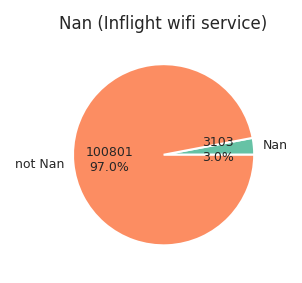

In [39]:
draw_nan(df_train, 'Inflight wifi service')

## 2. Drop nan data

In [40]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

## 3. Get Dummies

In [41]:
df_train = pd.get_dummies(df_train, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

## 4. Prepare Separate List

In [42]:
droplist = []
questionare = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
infos = ['Age','Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Gender_Male', 'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus']
 

# Model Training

In [43]:
def run_all_models(X_train, X_test, y_train, y_test, fs, impnum):
    mod_results = {}
    y_preds_train = {}
    y_preds = {}
    importance = {}

    # KNN
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors = 10, n_jobs=-1).fit(X_train, y_train)
    mod_results['KNN'] = my_metrics(knn, X_train, X_test, y_train, y_test, print_model=False)
    y_preds_train['KNN'] = knn.predict_proba(X_train)[:,1]
    y_preds['KNN'] = knn.predict_proba(X_test)[:,1]
    end = time.time()
    mod_results['KNN']['time(s)'] = (end - start)

    #GBM Classifier
    start = time.time()
    gb = GradientBoostingClassifier(n_estimators=1000,random_state=0).fit(X_train, y_train)
    mod_results['GradientBoostingClassifier'] = my_metrics(gb, X_train, X_test, y_train, y_test, print_model=False)
    y_preds_train['GradientBoostingClassifier'] = gb.predict_proba(X_train)[:,1]
    y_preds['GradientBoostingClassifier'] = gb.predict_proba(X_test)[:,1]
    end = time.time()
    mod_results['GradientBoostingClassifier']['time(s)'] = (end - start)

    fsim = dict(zip(fs,list(gb.feature_importances_)))
    flist = sorted(list(fsim.items()),key = lambda x: -x[1])
    for i in range(impnum):
        try: 
            importance[flist[i][0]] += 1
        except:
            importance[flist[i][0]] = 1

    #RF Classifier
    start = time.time()
    rf = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1).fit(X_train, y_train)
    mod_results['RandomForestClassifier'] = my_metrics(rf, X_train, X_test, y_train, y_test, print_model=False)
    y_preds_train['RandomForestClassifier'] = rf.predict_proba(X_train)[:,1]
    y_preds['RandomForestClassifier'] = rf.predict_proba(X_test)[:,1]
    end = time.time()
    mod_results['RandomForestClassifier']['time(s)'] = (end - start)

    fsim = dict(zip(fs,list(rf.feature_importances_)))
    flist = sorted(list(fsim.items()),key = lambda x: -x[1])
    for i in range(impnum):
        try: 
            importance[flist[i][0]] += 1
        except:
            importance[flist[i][0]] = 1


    #XGBoost Classifier
    start = time.time()
    xgb = XGBClassifier(eta = 0.1, min_child_weight = 3, max_depth = 10, eval_metric = 'auc', use_label_encoder = False, random_state = 0).fit(X_train, y_train)
    mod_results['XGBClassifier'] = my_metrics(xgb, X_train, X_test, y_train, y_test, print_model=False)
    y_preds_train['XGBClassifier'] = xgb.predict_proba(X_train)[:,1]
    y_preds['XGBClassifier'] = xgb.predict_proba(X_test)[:,1]
    end = time.time()
    mod_results['XGBClassifier']['time(s)'] = (end - start)

    fsim = dict(zip(fs,list(xgb.feature_importances_)))
    flist = sorted(list(fsim.items()),key = lambda x: -x[1])
    for i in range(impnum):
        try: 
            importance[flist[i][0]] += 1
        except:
            importance[flist[i][0]] = 1


    #Decision Tree Classifier
    start = time.time()
    dt = DecisionTreeClassifier(max_depth = 10, random_state=0).fit(X_train, y_train)
    mod_results['DecisionTreeClassifier'] = my_metrics(dt, X_train, X_test, y_train, y_test, print_model=False)
    y_preds_train['DecisionTreeClassifier'] = dt.predict_proba(X_train)[:,1]
    y_preds['DecisionTreeClassifier'] = dt.predict_proba(X_test)[:,1]
    end = time.time()
    mod_results['DecisionTreeClassifier']['time(s)'] = (end - start)

    fsim = dict(zip(fs,list(dt.feature_importances_)))
    flist = sorted(list(fsim.items()),key = lambda x: -x[1])
    for i in range(impnum):
        try: 
            importance[flist[i][0]] += 1
        except:
            importance[flist[i][0]] = 1

    #Ensemble
    start = time.time()
    
    tmp = np.zeros(len(y_train))
    for key, value in y_preds_train.items():
        tmp += value
        ensemble_pred_train = tmp / 5

    for i in range(ensemble_pred_train.shape[0]):
        if ensemble_pred_train[i] >= 0.5:
            ensemble_pred_train[i] = 1
        else:
            ensemble_pred_train[i] = 0
    
    tmp = np.zeros(len(y_test))
    for key, value in y_preds.items():
        tmp += value
        ensemble_pred = tmp / 5

    for i in range(ensemble_pred.shape[0]):
        if ensemble_pred[i] >= 0.5:
            ensemble_pred[i] = 1
        else:
            ensemble_pred[i] = 0
            
    mod_results['ensemble'] = {}
    mod_results['ensemble']['accuracy(train)'] = accuracy_score(y_train, ensemble_pred_train)
    mod_results['ensemble']['accuracy(test)'] = accuracy_score(y_test, ensemble_pred)
    mod_results['ensemble']['precision'] = precision_score(y_test, ensemble_pred)
    mod_results['ensemble']['recall'] = recall_score(y_test, ensemble_pred)
    mod_results['ensemble']['f1-score'] = f1_score(y_test, ensemble_pred)
    end = time.time()
    mod_results['ensemble']['time(s)'] = (end - start)

    return mod_results, importance

## 1. All columns

In [44]:
X_train, fs, myscaler = my_preprocessing(df_train, droplist, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train.loc[:, df_train.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test, droplist, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test.loc[:, df_test.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_all = pd.DataFrame.from_dict(mod_results)
results_df_all

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.946361,0.964754,1.000000,0.979123,0.947660,0.976083
accuracy(test),0.938333,0.960402,0.962378,0.964059,0.943209,0.962798
precision,0.963723,0.969584,0.972197,0.973071,0.941206,0.972989
recall,0.890191,0.937378,0.939429,0.942556,0.925850,0.939625
f1-score,0.925499,0.953209,0.955532,0.957570,0.933465,0.956016
time(s),468.343431,109.717337,19.841922,4.529999,0.315587,0.059497


In [45]:
importance_all = sorted(list(importance.items()),key = lambda x: -x[1])
importance_all

[('Online boarding', 4),
 ('Type of Travel_Personal Travel', 4),
 ('Inflight wifi service', 4),
 ('Inflight entertainment', 4),
 ('Customer Type_disloyal Customer', 4),
 ('Class_Eco', 4),
 ('Leg room service', 4),
 ('Checkin service', 3),
 ('Baggage handling', 3),
 ('On-board service', 2),
 ('Gate location', 2),
 ('Seat comfort', 1),
 ('Flight Distance', 1)]

## 2. Info only

In [46]:
X_train, fs, myscaler = my_preprocessing(df_train, questionare, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train.loc[:, df_train.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test, questionare, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test.loc[:, df_test.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 5)
results_df_info = pd.DataFrame.from_dict(mod_results)
results_df_info

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.822103,0.819127,0.993617,0.833255,0.816937,0.858345
accuracy(test),0.790575,0.806507,0.773088,0.806129,0.803985,0.805540
precision,0.761497,0.761441,0.737017,0.762706,0.755525,0.762985
recall,0.747362,0.801387,0.734857,0.797577,0.804904,0.795037
f1-score,0.754363,0.780903,0.735936,0.779752,0.779433,0.778681
time(s),32.569624,54.310333,26.373305,2.071842,0.184411,0.059311


In [47]:
importance_info = sorted(list(importance.items()),key = lambda x: -x[1])
importance_info

[('Type of Travel_Personal Travel', 4),
 ('Class_Eco', 4),
 ('Age', 4),
 ('Customer Type_disloyal Customer', 3),
 ('Class_Eco Plus', 2),
 ('Arrival Delay in Minutes', 2),
 ('Flight Distance', 1)]

## 3. Questionare only

In [48]:
X_train, fs, myscaler = my_preprocessing(df_train, infos, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train.loc[:, df_train.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test, infos, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test.loc[:, df_test.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_q = pd.DataFrame.from_dict(mod_results)
results_df_q

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.937400,0.945208,0.995462,0.964838,0.932285,0.967196
accuracy(test),0.926857,0.942032,0.946446,0.948590,0.924923,0.947076
precision,0.946312,0.947730,0.952078,0.956262,0.931475,0.955085
recall,0.879934,0.915787,0.921942,0.922724,0.891071,0.920281
f1-score,0.911917,0.931485,0.936768,0.939194,0.910825,0.937360
time(s),80.057462,61.783546,17.506142,3.129001,0.199177,0.060261


In [49]:
importance_q = sorted(list(importance.items()),key = lambda x: -x[1])
importance_q

[('Online boarding', 4),
 ('Inflight wifi service', 4),
 ('Inflight entertainment', 4),
 ('Leg room service', 4),
 ('Departure/Arrival time convenient', 4),
 ('Gate location', 4),
 ('On-board service', 4),
 ('Seat comfort', 2),
 ('Baggage handling', 2),
 ('Ease of Online booking', 2),
 ('Food and drink', 2),
 ('Cleanliness', 2),
 ('Checkin service', 1),
 ('Inflight service', 1)]

## 4. Loyal Only

In [50]:
df_train_loyal = df_train[df_train['Customer Type_disloyal Customer'] == 0]
df_test_loyal = df_test[df_test['Customer Type_disloyal Customer'] == 0]
X_train, fs, myscaler = my_preprocessing(df_train_loyal, droplist, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train_loyal.loc[:, df_train_loyal.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test_loyal, droplist, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test_loyal.loc[:, df_test_loyal.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_all_l = pd.DataFrame.from_dict(mod_results)
results_df_all_l

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.951244,0.971401,1.000000,0.982866,0.956103,0.979269
accuracy(test),0.944464,0.965415,0.967470,0.968673,0.951581,0.967671
precision,0.972519,0.977867,0.980769,0.983966,0.968075,0.983086
recall,0.909043,0.948837,0.950311,0.949679,0.928940,0.948416
f1-score,0.939711,0.963133,0.965300,0.966518,0.948104,0.965440
time(s),322.789658,88.423885,15.283279,3.186898,0.228857,0.050316


In [51]:
importance_all_l = sorted(list(importance.items()),key = lambda x: -x[1])
importance_all_l

[('Type of Travel_Personal Travel', 4),
 ('Online boarding', 4),
 ('Inflight entertainment', 4),
 ('Inflight wifi service', 4),
 ('Seat comfort', 4),
 ('Cleanliness', 4),
 ('Baggage handling', 4),
 ('Checkin service', 3),
 ('Leg room service', 2),
 ('On-board service', 2),
 ('Gate location', 2),
 ('Inflight service', 2),
 ('Class_Eco', 1)]

## 5. Disloyal Only

In [52]:
df_train_disloyal = df_train[df_train['Customer Type_disloyal Customer'] == 1]
df_test_disloyal = df_test[df_test['Customer Type_disloyal Customer'] == 1]
X_train, fs, myscaler = my_preprocessing(df_train_disloyal, droplist, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train_disloyal.loc[:, df_train_disloyal.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test_disloyal, droplist, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test_disloyal.loc[:, df_test_disloyal.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_all_dl = pd.DataFrame.from_dict(mod_results)
results_df_all_dl

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.920806,0.972494,1.000000,0.975622,0.956720,0.975101
accuracy(test),0.906722,0.937989,0.939552,0.940855,0.932256,0.940855
precision,0.830716,0.847978,0.859175,0.852210,0.815894,0.856145
recall,0.645862,0.824966,0.819539,0.837178,0.835821,0.831750
f1-score,0.726718,0.836314,0.838889,0.844627,0.825737,0.843772
time(s),11.208143,16.204217,3.195156,0.539518,0.039930,0.010540


In [53]:
importance_all_dl = sorted(list(importance.items()),key = lambda x: -x[1])
importance_all_dl

[('Inflight wifi service', 4),
 ('Age', 4),
 ('Baggage handling', 4),
 ('Inflight service', 4),
 ('On-board service', 4),
 ('Checkin service', 4),
 ('Flight Distance', 3),
 ('Class_Eco', 3),
 ('Gate location', 2),
 ('Arrival Delay in Minutes', 2),
 ('Departure/Arrival time convenient', 2),
 ('Ease of Online booking', 1),
 ('Online boarding', 1),
 ('Class_Eco Plus', 1),
 ('Departure Delay in Minutes', 1)]

## 6. Loyal + Questionare

In [58]:
df_train_loyal = df_train[df_train['Customer Type_disloyal Customer'] == 0]
df_test_loyal = df_test[df_test['Customer Type_disloyal Customer'] == 0]
X_train, fs, myscaler = my_preprocessing(df_train_loyal, infos, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train_loyal.loc[:, df_train_loyal.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test_loyal, infos, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test_loyal.loc[:, df_test_loyal.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_all_l_q = pd.DataFrame.from_dict(mod_results)
results_df_all_l_q

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.943839,0.956090,0.996790,0.972600,0.945038,0.971938
accuracy(test),0.934289,0.953887,0.956393,0.959401,0.938399,0.957546
precision,0.956309,0.962081,0.964874,0.968713,0.947220,0.968283
recall,0.903253,0.940204,0.942731,0.945257,0.921992,0.941678
f1-score,0.929024,0.951017,0.953674,0.956841,0.934436,0.954795
time(s),34.229504,51.052240,13.626997,2.601732,0.162439,0.050642


In [59]:
importance_all_l_q = sorted(list(importance.items()),key = lambda x: -x[1])
importance_all_l_q

[('Online boarding', 4),
 ('Inflight wifi service', 4),
 ('Inflight entertainment', 4),
 ('Leg room service', 4),
 ('Departure/Arrival time convenient', 4),
 ('Gate location', 4),
 ('Seat comfort', 3),
 ('Cleanliness', 3),
 ('On-board service', 2),
 ('Checkin service', 2),
 ('Baggage handling', 2),
 ('Food and drink', 2),
 ('Inflight service', 2)]

In [60]:
df_loyal_plot = df_train_loyal[[i[0] for i in importance_all_l_q]].append(df_test_loyal[[i[0] for i in importance_all_l_q]])
df_loyal_plot

,Online boarding,Inflight wifi service,Inflight entertainment,Leg room service,Departure/Arrival time convenient,Gate location,Seat comfort,Cleanliness,On-board service,Checkin service,Baggage handling,Food and drink,Inflight service
0,3.0,3.0,5.0,3.0,4.0,1.0,5.0,5.0,4.0,4.0,4,5.0,5.0
2,5.0,2.0,5.0,3.0,2.0,2.0,5.0,5.0,4.0,4.0,4,5.0,4.0
3,2.0,2.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,1.0,3,2.0,4.0
4,5.0,3.0,3.0,4.0,3.0,3.0,5.0,3.0,3.0,3.0,4,4.0,3.0
5,2.0,3.0,1.0,4.0,4.0,1.0,1.0,1.0,3.0,4.0,4,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25969,4.0,3.0,4.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4,3.0,4.0
25972,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,5,4.0,5.0
25973,1.0,2.0,2.0,3.0,5.0,5.0,2.0,2.0,4.0,5.0,4,2.0,4.0
25974,4.0,3.0,4.0,2.0,3.0,3.0,4.0,4.0,3.0,4.0,5,4.0,5.0


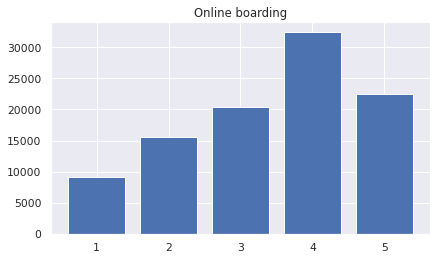

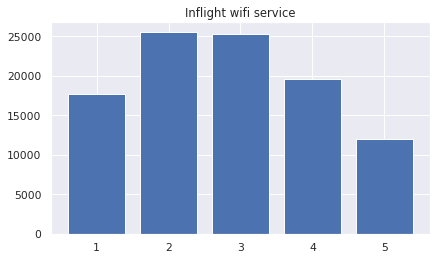

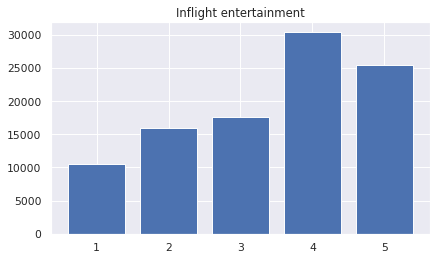

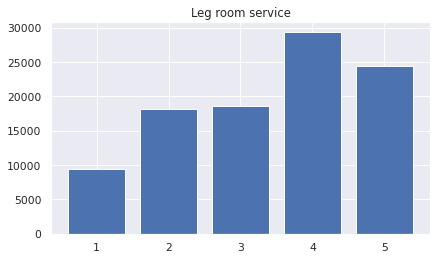

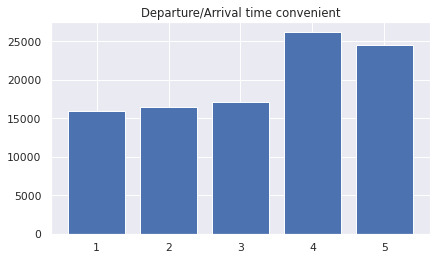

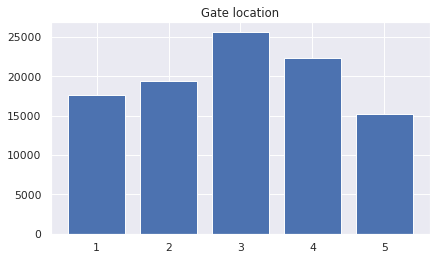

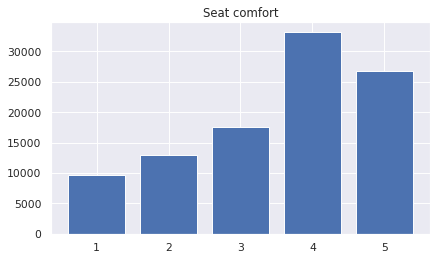

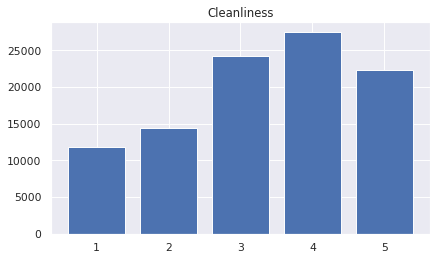

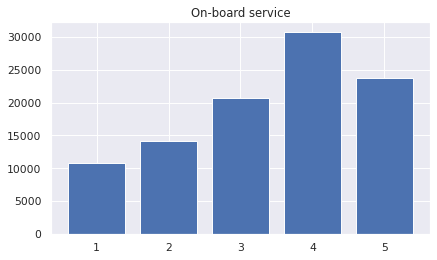

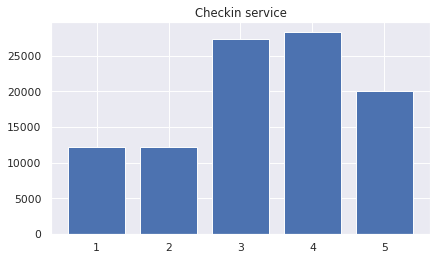

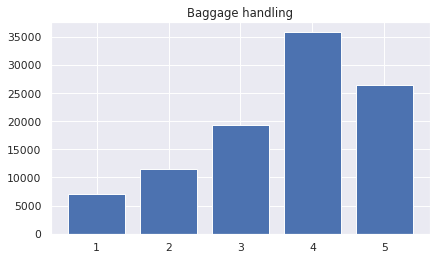

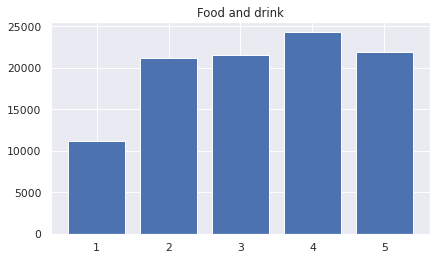

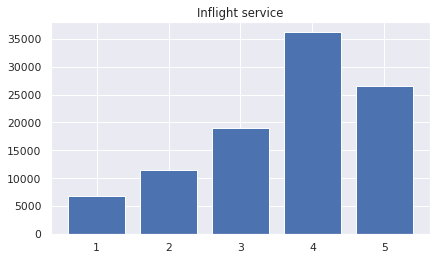

In [61]:
for i in df_loyal_plot.columns.tolist():
    x = df_loyal_plot[i].value_counts().sort_index().index.tolist()
    y = df_loyal_plot[i].value_counts().sort_index().tolist()
    plt.bar(x,y)
    plt.title(i)
    plt.show()

## 7. Disloyal + Questionare

In [54]:
df_train_disloyal = df_train[df_train['Customer Type_disloyal Customer'] == 1]
df_test_disloyal = df_test[df_test['Customer Type_disloyal Customer'] == 1]
X_train, fs, myscaler = my_preprocessing(df_train_disloyal, infos, processing_type = processing, trainingdata = True, scaler = None)
y_train = np.ravel(df_train_disloyal.loc[:, df_train_disloyal.columns == 'satisfaction_satisfied'])
X_test, fs, scaler = my_preprocessing(df_test_disloyal, infos, processing_type = processing, trainingdata = False, scaler = myscaler)
y_test = np.ravel(df_test_disloyal.loc[:, df_test_disloyal.columns == 'satisfaction_satisfied'])

mod_results, importance = run_all_models(X_train, X_test, y_train, y_test, fs, 10)
results_df_all_dl_q = pd.DataFrame.from_dict(mod_results)
results_df_all_dl_q

,KNN,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier,DecisionTreeClassifier,ensemble
accuracy(train),0.924847,0.947856,0.995503,0.961087,0.942185,0.965976
accuracy(test),0.909067,0.927045,0.923137,0.926003,0.930172,0.929130
precision,0.822259,0.813443,0.813920,0.816783,0.792030,0.823366
recall,0.671642,0.804613,0.777476,0.792402,0.862958,0.803256
f1-score,0.739358,0.809004,0.795281,0.804408,0.825974,0.813187
time(s),4.993560,9.562832,3.060886,0.455136,0.027166,0.010458


In [55]:
importance_all_dl_q = sorted(list(importance.items()),key = lambda x: -x[1])
importance_all_dl_q

[('Inflight wifi service', 4),
 ('Baggage handling', 4),
 ('Inflight service', 4),
 ('On-board service', 4),
 ('Checkin service', 4),
 ('Gate location', 4),
 ('Departure/Arrival time convenient', 4),
 ('Leg room service', 3),
 ('Online boarding', 3),
 ('Ease of Online booking', 2),
 ('Inflight entertainment', 1),
 ('Food and drink', 1),
 ('Seat comfort', 1),
 ('Cleanliness', 1)]

In [56]:
df_disloyal_plot = df_train_disloyal[[i[0] for i in importance_all_dl_q]].append(df_test_disloyal[[i[0] for i in importance_all_dl_q]])
df_disloyal_plot

,Inflight wifi service,Baggage handling,Inflight service,On-board service,Checkin service,Gate location,Departure/Arrival time convenient,Leg room service,Online boarding,Ease of Online booking,Inflight entertainment,Food and drink,Seat comfort,Cleanliness
1,3.0,3,4.0,1.0,1.0,3.0,2.0,5.0,3.0,3.0,1.0,1.0,1.0,1.0
9,3.0,4,3.0,2.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0
10,4.0,5,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0,2.0,2.0,2.0,2.0
15,2.0,4,3.0,2.0,1.0,3.0,1.0,1.0,2.0,2.0,4.0,4.0,1.0,4.0
31,2.0,4,4.0,3.0,2.0,3.0,2.0,1.0,2.0,2.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25962,4.0,1,1.0,2.0,2.0,1.0,4.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0
25966,4.0,2,3.0,3.0,2.0,2.0,4.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0
25967,1.0,4,4.0,5.0,4.0,3.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0
25970,1.0,5,3.0,5.0,2.0,3.0,5.0,2.0,1.0,1.0,4.0,4.0,4.0,4.0


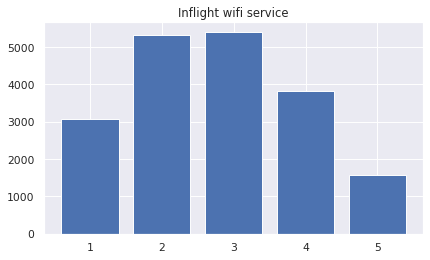

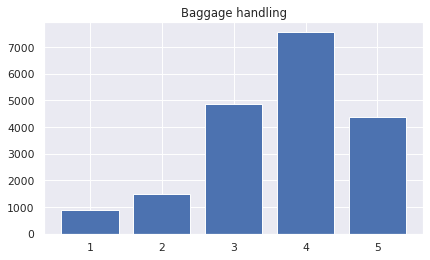

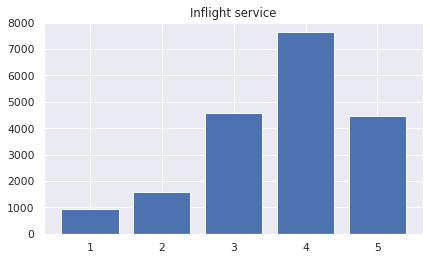

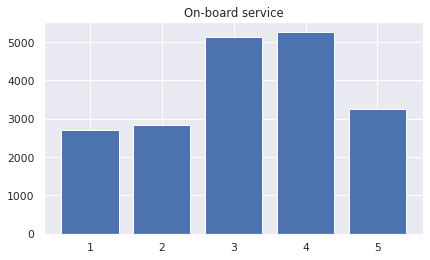

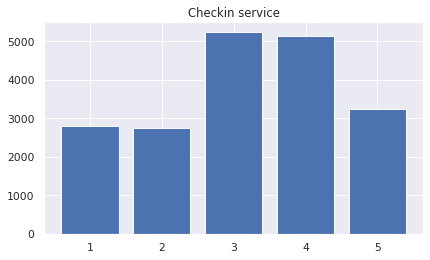

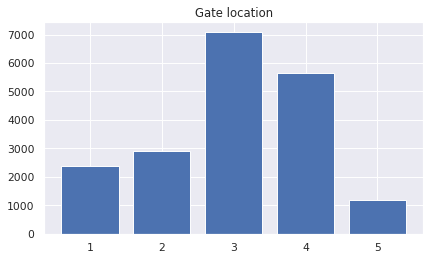

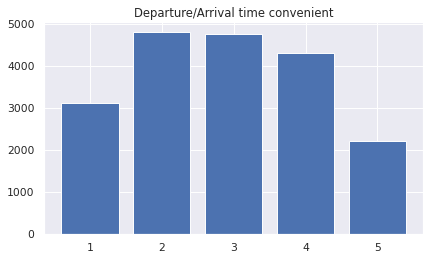

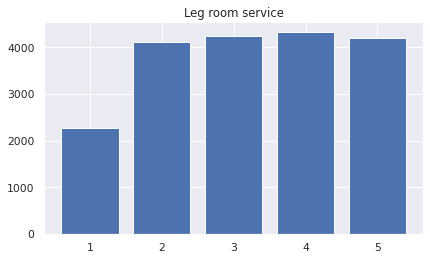

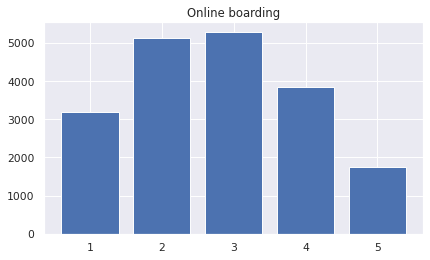

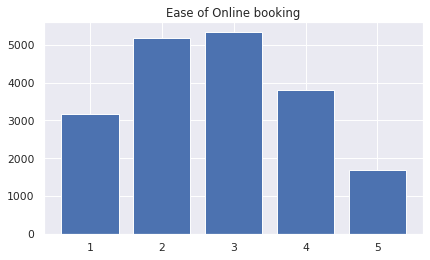

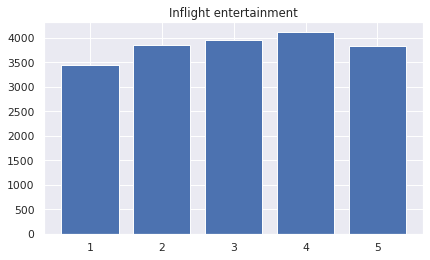

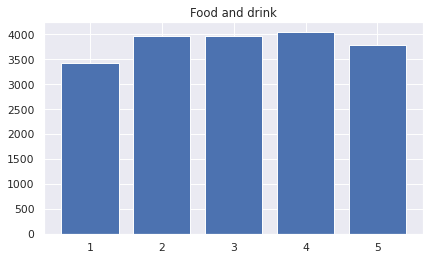

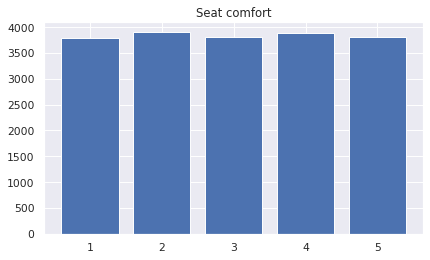

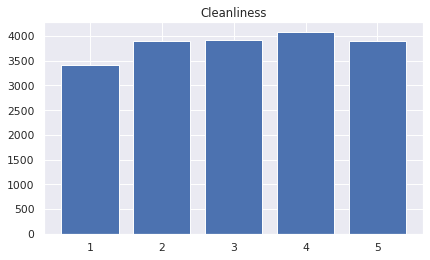

In [57]:
for i in df_disloyal_plot.columns.tolist():
    x = df_disloyal_plot[i].value_counts().sort_index().index.tolist()
    y = df_disloyal_plot[i].value_counts().sort_index().tolist()
    plt.bar(x,y)
    plt.title(i)
    plt.show()